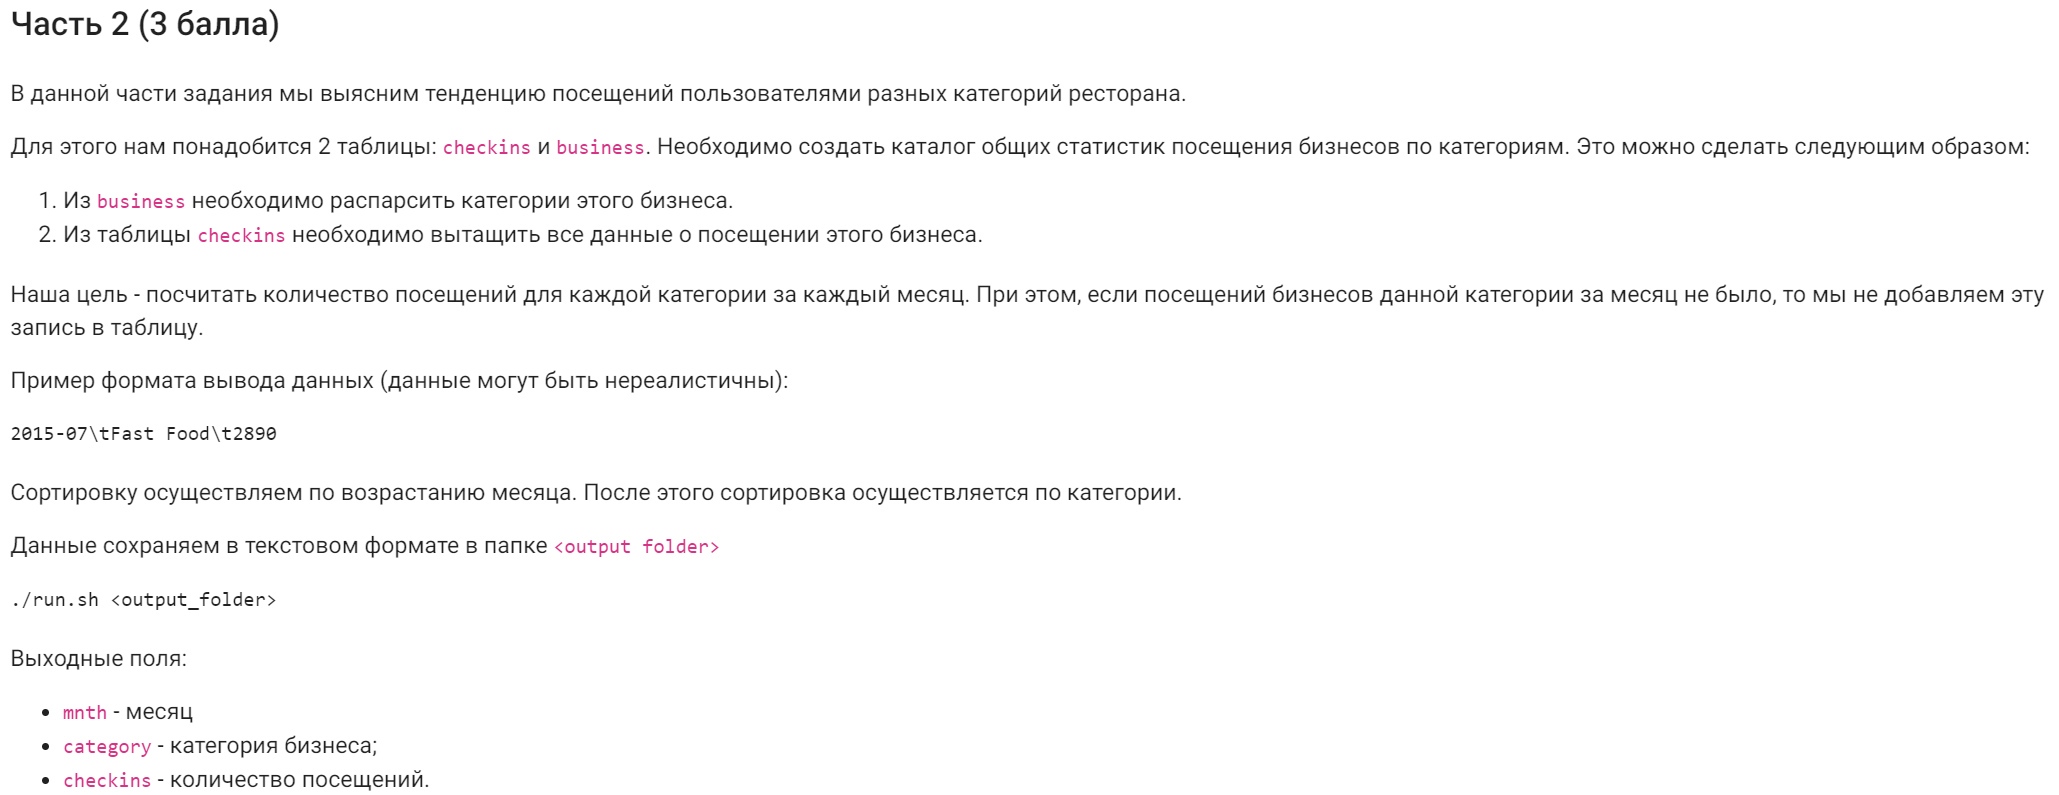

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [2]:
spark = SparkSession.builder.appName('Spark DF task1').master('yarn').getOrCreate()

In [3]:
business = (spark.read.format("json")
    .load("/data/yelp/business")
)

In [4]:
business.show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------
 address      | 1616 Chapala St, Ste 2                                                                                     
 attributes   | [,,,,,,,,,,, True,,,,,,,,,,,,,,,,,,,,,,,,,,,]                                                              
 business_id  | Pns2l4eNsfO8kk83dixA6A                                                                                     
 categories   | Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists 
 city         | Santa Barbara                                                                                              
 hours        | null                                                                                                       
 is_open      | 0                                                                                                          
 latitud

In [6]:
checkins = (spark.read.format("json")
    .load("/data/yelp/checkin")
)

In [7]:
checkins.show(1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id | ---kPU91CF4Lq2-WlRu9Lw                                                                                                                                                                                                                
 date        | 2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020-07-24 22:42:27, 2020-10-24 21:36:13, 2020-12-09 21:23:33, 2021-01-20 17:34:57, 2021-04-30 21:02:03, 2021-05-25 21:16:54, 2021-08-06 21:08:08, 2021-10-02 15:15:42, 2021-11-11 16:23:50 
only showing top 1 row



In [8]:
business_shot = business.select("business_id", "categories")

In [9]:
business_shot.show(1, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A                                                                                     
 categories  | Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists 
only showing top 1 row



In [13]:
business_parsed = business_shot.withColumn("category", f.explode(f.split(business_shot["categories"], ", ")))

In [16]:
business_parsed = business_parsed.select("business_id", "category")

In [17]:
business_parsed.show(15, truncate=False, vertical=True)

-RECORD 0-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Doctors                      
-RECORD 1-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Traditional Chinese Medicine 
-RECORD 2-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Naturopathic/Holistic        
-RECORD 3-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Acupuncture                  
-RECORD 4-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Health & Medical             
-RECORD 5-----------------------------------
 business_id | Pns2l4eNsfO8kk83dixA6A       
 category    | Nutritionists                
-RECORD 6-----------------------------------
 business_id | mpf3x-BjTdTEA3yCZrAYPw       
 category    | Shipping Centers             
-RECORD 7-----------------------------------
 business_

In [18]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = 10")
business_checkins = business_parsed.join(f.broadcast(checkins), on='business_id', how='inner')

In [21]:
business_checkins.show(15, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
business_checkins_parsed = business_checkins.withColumn("checkin_date", f.explode(f.split(business_checkins["date"], ", ")))

In [25]:
business_checkins_parsed = business_checkins_parsed.select("business_id", "category", "checkin_date")

In [27]:
business_checkins_parsed.show(30)

+--------------------+--------------------+-------------------+
|         business_id|            category|       checkin_date|
+--------------------+--------------------+-------------------+
|Pns2l4eNsfO8kk83d...|             Doctors|2018-09-21 20:51:31|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|2018-09-21 20:51:31|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|2018-09-21 20:51:31|
|Pns2l4eNsfO8kk83d...|         Acupuncture|2018-09-21 20:51:31|
|Pns2l4eNsfO8kk83d...|    Health & Medical|2018-09-21 20:51:31|
|Pns2l4eNsfO8kk83d...|       Nutritionists|2018-09-21 20:51:31|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2011-12-12 23:30:26|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-05-23 20:31:34|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-10-23 17:54:53|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-11-01 18:34:10|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2015-06-12 22:52:10|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2015-10-03 17:17:23|
|mpf3x-BjTdTEA3yCZ...|    Shipping Cente

In [29]:
business_checkins_month = business_checkins_parsed.withColumn("year_month", f.date_format("checkin_date", "yyyy-MM"))

In [30]:
business_checkins_month.show(30)

+--------------------+--------------------+-------------------+----------+
|         business_id|            category|       checkin_date|year_month|
+--------------------+--------------------+-------------------+----------+
|Pns2l4eNsfO8kk83d...|             Doctors|2018-09-21 20:51:31|   2018-09|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|2018-09-21 20:51:31|   2018-09|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|2018-09-21 20:51:31|   2018-09|
|Pns2l4eNsfO8kk83d...|         Acupuncture|2018-09-21 20:51:31|   2018-09|
|Pns2l4eNsfO8kk83d...|    Health & Medical|2018-09-21 20:51:31|   2018-09|
|Pns2l4eNsfO8kk83d...|       Nutritionists|2018-09-21 20:51:31|   2018-09|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2011-12-12 23:30:26|   2011-12|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-05-23 20:31:34|   2014-05|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-10-23 17:54:53|   2014-10|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|2014-11-01 18:34:10|   2014-11|
|mpf3x-BjTdTEA3yCZ...|   

In [37]:
business_checkins_month.registerTempTable("business_checkins_month")

In [48]:
query_str = """
SELECT year_month,
       category, 
       count(checkin_date)
FROM business_checkins_month
GROUP BY year_month, category
ORDER BY year_month, category
"""

In [49]:
spark.sql(query_str).show(50)

+----------+--------------------+-------------------+
|year_month|            category|count(checkin_date)|
+----------+--------------------+-------------------+
|   2009-12|American (Traditi...|                  1|
|   2009-12|  Breakfast & Brunch|                  1|
|   2009-12|              Diners|                  1|
|   2009-12|              Indian|                  1|
|   2009-12|         Restaurants|                  2|
|   2010-01|         Accessories|                  6|
|   2010-01|         Active Life|                 44|
|   2010-01|     Adult Education|                  2|
|   2010-01| Adult Entertainment|                  2|
|   2010-01|            Airlines|                  4|
|   2010-01|            Airports|                 27|
|   2010-01|          Allergists|                  1|
|   2010-01|Amateur Sports Teams|                  3|
|   2010-01|      American (New)|                245|
|   2010-01|American (Traditi...|                232|
|   2010-01|     Amusement P

In [50]:
statistic = spark.sql(query_str)

In [ ]:
statistic.write.csv("business_review_counts.tsv", sep='\t', mode='overwrite')

In [51]:
! hdfs dfs -cat student44/* | head -n 100 

2009-12	American (Traditional)	1
2009-12	Breakfast & Brunch	1
2009-12	Diners	1
2009-12	Indian	1
2009-12	Restaurants	2
2010-01	Accessories	6
2010-01	Active Life	44
2010-01	Adult Education	2
2010-01	Adult Entertainment	2
2010-01	Airlines	4
2010-01	Airports	27
2010-01	Allergists	1
2010-01	Amateur Sports Teams	3
2010-01	American (New)	245
2010-01	American (Traditional)	232
2010-01	Amusement Parks	7
2010-01	Apartments	2
2010-01	Appliances	13
2010-01	Appliances & Repair	3
2010-01	Arcades	6
2010-01	Architects	1
2010-01	Argentine	1
2010-01	Art Classes	2
2010-01	Art Galleries	14
2010-01	Art Museums	3
2010-01	Art Schools	7
2010-01	Art Supplies	4
2010-01	Arts & Crafts	8
2010-01	Arts & Entertainment	126
2010-01	Asian Fusion	32
2010-01	Auto Detailing	1
2010-01	Auto Parts & Supplies	5
2010-01	Auto Repair	6
2010-01	Automotive	23
2010-01	Bagels	25
2010-01	Bakeries	59
2010-01	Banks & Credit Unions	2
2010-01	Barbeque	35
2010-01	Barbers	6
2010-01	Bars	418
2010-01	Bartenders	2
2010-01	Basque	4
2010-01	Bea

cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to o